In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
!pip install keras-tuner
from kerastuner import RandomSearch ,Hyperband


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


<ipython-input-4-6919aa7e312f>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch ,Hyperband


In [5]:
# load and prepare data'

data=load_diabetes()
data.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [6]:
data.data.shape

(442, 10)

In [7]:
data.target.shape

(442,)

In [8]:
X_train,X_test,y_train,y_test=train_test_split(data.data,data.target,test_size=0.2,random_state=42)

In [9]:
# print the shape of all the dataset
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(353, 10) (89, 10) (353,) (89,)


In [10]:
# scale the dataset

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [11]:
X_train

array([[ 1.49836523,  1.06136988,  0.21990201, ...,  0.71103773,
         0.54748197, -0.06144896],
       [-0.22885822,  1.06136988, -0.41936607, ...,  1.4842858 ,
        -0.01975653,  0.36723647],
       [ 0.08518241, -0.94217861,  1.01898711, ..., -0.06221033,
         0.3312366 , -0.31866022],
       ...,
       [ 0.63475351, -0.94217861, -0.46502808, ..., -0.83545839,
        -0.25375196, -0.06144896],
       [-0.30736838, -0.94217861, -0.53352109, ..., -0.06221033,
        -0.83072436, -0.83308273],
       [-2.03459183, -0.94217861,  0.56236706, ..., -0.83545839,
        -0.13312789, -0.06144896]])

In [17]:
# Build ANN basic model

def build_model():
  model=Sequential()
  model.add(Dense(128,activation='relu', input_shape=(X_train.shape[1],)))
  model.add(Dense(64,activation='relu'))
  model.add(Dense(32,activation='relu'))
  model.add(Dense(1))

  model.compile(optimizer='Adam',loss='mse')
  return model

In [19]:
# initilize the model

model=build_model()

# train the model

train=model.fit(X_train,y_train,validation_split=0.2,batch_size=32,epochs=30)

# evaluate the model
y_pred=model.predict(X_test)
mse=mean_squared_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)
print(mse,r2)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 29358.4707 - val_loss: 22335.0215
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 29850.3906 - val_loss: 22122.4785
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 31152.3398 - val_loss: 21750.8164
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 29929.1504 - val_loss: 21072.2090
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 30297.5371 - val_loss: 19868.8398
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 26680.2461 - val_loss: 17871.4219
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 21777.3828 - val_loss: 14852.5947
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 19438.8555 - val_loss: 10891.5371
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 13342.5576 - val_loss: 6828.0903
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7730.9185 - val_loss: 4264.6558
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5307.2808 - val_loss: 3650.7373
Epoch 12/30
9

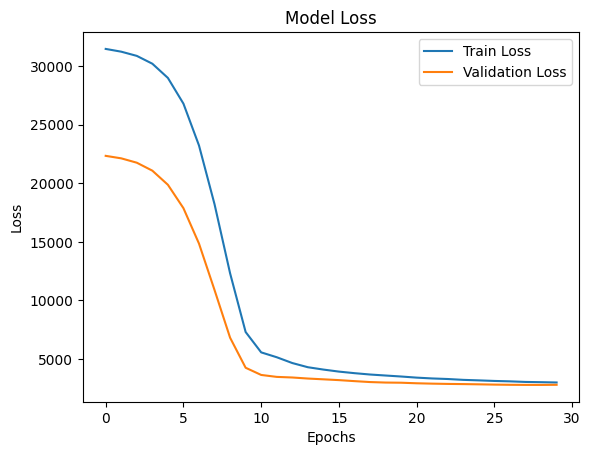

In [21]:
# Plot training & validation loss
plt.plot(train.history['loss'], label='Train Loss')
plt.plot(train.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Define a function for the model builder
def model_builder(hp):
    model = Sequential()

    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu', input_shape=(X_train.shape[1],)))

    # Tune the number of hidden layers and the units in each
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'layer_{i}_units', min_value=32, max_value=512, step=32), activation='relu'))

    # Tune dropout rate
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Tune the learning rate
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')

    return model

# Initialize the Keras Tuner with Random Search
tuner = RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='hyperparameter_tuning',
    project_name='diabetes_regression'
)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal number of units in the first dense layer is {best_hps.get('units')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


Trial 10 Complete [00h 00m 31s]
val_loss: 2750.2161865234375

Best val_loss So Far: 2734.2916259765625
Total elapsed time: 00h 05m 39s

The optimal number of units in the first dense layer is 224.
The optimal learning rate is 0.0070492237192470684.



Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 27219.4707 - val_loss: 4792.5820
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7915.7148 - val_loss: 3336.1753
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5275.2109 - val_loss: 3520.2844
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5541.9375 - val_loss: 3141.2302
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4866.2290 - val_loss: 2928.7390
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4038.2136 - val_loss: 2782.3015
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3857.7190 - val_loss: 2782.8604
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3733.3169 - val_loss: 2807.2751
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3667.7004 - val_loss: 2846.1082
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4075.9526 - val_loss: 2874.9104
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4277.8120 - val_loss: 2851.7375
Epoch 12/200
9/9

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Fine-Tuned Mean Squared Error: 4400.3130


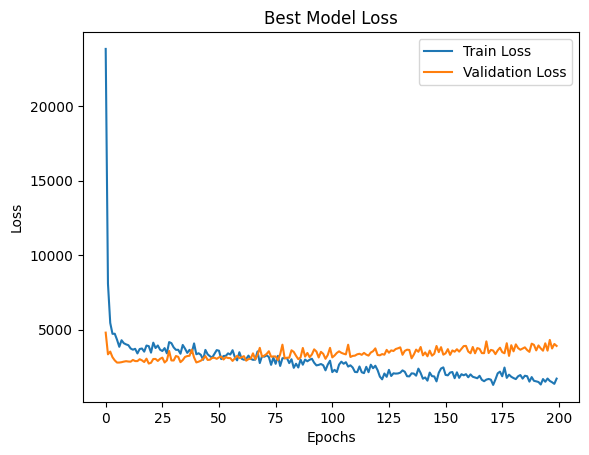

In [23]:
# Build the best model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history_best = best_model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32, verbose=1)

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
print(f"Fine-Tuned Mean Squared Error: {mse_best:.4f}")

# Plot training & validation loss for the best model
plt.plot(history_best.history['loss'], label='Train Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.title('Best Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
# Save the best model
best_model.save('best_model.h5')

# Load the model later
from tensorflow.keras.models import load_model
loaded_model = load_model('best_model.h5')

# Evaluate the loaded model
y_pred_loaded = loaded_model.predict(X_test)
mse_loaded = mean_squared_error(y_test, y_pred_loaded)
print(f"Loaded Model Mean Squared Error: {mse_loaded:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Loaded Model Mean Squared Error: 4400.3130
